# Kimchi Premium

In [1]:
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc
import polars as pl

kor_excs = ['upbit']
global_excs = ['binance', 'bitfinex', 'coinbase', 'okx']
# 'kraken', 'binanceus', 'bitstamp', 'kucoin', 'gateio', 'bitmex', 'bybit', 'huobi',

df = pq.read_table('../tradingview_ohlcv.parquet').drop_columns(['open', 'high', 'low',])
df = df.filter(pc.is_in(df['Exchange'], pa.array(kor_excs + global_excs)))
df = df.filter(pc.is_in(df['Perpetual'], pa.array([False]))).drop_columns(['Perpetual'])

df

pyarrow.Table
time: int64
close: double
Volume: double
Exchange: large_string
Pair: large_string
Interval: int16
FileName: large_string
----
time: [[1751923800,1684350000,1749168000,1723759200,1733273100,...,1733366700,1750562460,1732670100,1715781600,1749170700],[1749474000,1718271000,1746442800,1722754800,1740893400,...,1745098200,1747270800,1746873600,1726249500,1741948800],...,[1741204800,1733257800,1702440000,1658620800,1740517200,...,1690354800,1748708400,1734634800,1743153300,1747386000],[1715706000,1750089960,1626091200,1733722800,1705280400,...,1715828400,1750655400,1739144700,1681365600,1699963200]]
close: [[2.8426,0.448,0.17022,2577.47,13750,...,0.697,102420,0.43127,64187.5,0.25794],[2.2483,0.626,94116.69,140.7,0.000007721,...,3.83,3.9184,238150,2411.88,2.2396],...,[0.989,2.5208,0.63010935,0.3585,87966.16,...,29223.55,156.55,313.38,0.2756,3.8707],[0.8991,2.3058,0.636,5969,95.72,...,0.5176,101308.1,2.3971,39706000,36327.84]]
Volume: [[191448,898751,14735938.474234,3357.177328

In [2]:
import pandas as pd 

def price_diff(df, kor_exc, global_exc):

    glob = df.filter(pc.equal(df['Exchange'], global_exc)).drop_columns(['Exchange', 'Pair', 'FileName'])
    kor = df.filter(pc.equal(df['Exchange'], kor_exc)).drop_columns(['Exchange', 'Pair', 'FileName'])

    # merge by time using pyarrow
    df_merged = glob.join(
        kor, ['time', 'Interval'], join_type='inner', 
        left_suffix=f'_{global_exc}', right_suffix=f'_{kor_exc}').combine_chunks()
    print(df_merged.num_rows, 'rows after merge')

    # price error = (upbit - binance) / upbit

    diff = pc.subtract(df_merged[f'close_{kor_exc}'], df_merged[f'close_{global_exc}'])
    price_diff = pc.divide(diff, df_merged[f'close_{kor_exc}'])

    df_merged = df_merged.append_column(
        'price_error', price_diff).set_column(
        0,  # 첫 번째 컬럼 인덱스
        'time',
        pc.cast(df_merged['time'], pa.timestamp('s'))
    ).to_pandas().sort_values(by='time')
    df_merged.time = df_merged.time.dt.tz_localize('UTC').dt.tz_convert('Asia/Seoul')
    # df_merged = df_merged.set_index('time').resample('5min').fillna(0)
    
    
    
    print(df_merged.duplicated().shape[0], 'duplicated rows')
    return df_merged

In [3]:
import os
root_folder = os.path.join(os.getcwd(), '../kimchi-premium')
#  'LTCUSDC',PEPEUSDC', 'DOGEUSDC', 'ADAUSDC',/
for i in range(2):
    for token in ['BTCUSDC', 'ETHUSDC', 'XRPUSDC', 'SOLUSDC' ]:
        if i == 0:
            token = token.replace('USDC', 'USDT')
        for kor_exc in kor_excs:
            for global_exc in global_excs:
                print(f"Processing {kor_exc} vs {global_exc}")
                df_result = price_diff( df.filter(pc.is_in(df['Pair'], pa.array([token]))), kor_exc, global_exc)
                if df_result.empty:
                    print(f"❌ No data for {token} with {kor_exc} vs {global_exc}")
                    continue
                print(df_result.columns)
                df_result.to_csv(os.path.join(root_folder, f'{token}_{kor_exc}_{global_exc}_price_diff.csv'), index=False)
                print(f"✅ Saved {token}_{kor_exc}_{global_exc}_price_diff.csv with {df_result.shape[0]} rows")

Processing upbit vs binance
72061 rows after merge
72061 duplicated rows
Index(['time', 'close_binance', 'Volume_binance', 'Interval', 'close_upbit',
       'Volume_upbit', 'price_error'],
      dtype='object')
✅ Saved BTCUSDT_upbit_binance_price_diff.csv with 72061 rows
Processing upbit vs bitfinex
0 rows after merge
0 duplicated rows
❌ No data for BTCUSDT with upbit vs bitfinex
Processing upbit vs coinbase
72018 rows after merge
72018 duplicated rows
Index(['time', 'close_coinbase', 'Volume_coinbase', 'Interval', 'close_upbit',
       'Volume_upbit', 'price_error'],
      dtype='object')
✅ Saved BTCUSDT_upbit_coinbase_price_diff.csv with 72018 rows
Processing upbit vs okx
72065 rows after merge
72065 duplicated rows
Index(['time', 'close_okx', 'Volume_okx', 'Interval', 'close_upbit',
       'Volume_upbit', 'price_error'],
      dtype='object')
✅ Saved BTCUSDT_upbit_okx_price_diff.csv with 72065 rows
Processing upbit vs binance
43791 rows after merge
43791 duplicated rows
Index(['time

Visualizing BTCUSDT - upbit vs binance
Processing Interval: 20
Processing Interval: 60
Visualizing BTCUSDT - upbit vs coinbase
Processing Interval: 20
Processing Interval: 60
Skipping BTCUSDT_upbit_binanceus_price_diff.csv as it does not match the expected exchanges.
Visualizing ETHUSDT - upbit vs binance
Processing Interval: 20
Processing Interval: 60
Visualizing ETHUSDT - upbit vs coinbase
Processing Interval: 20
Processing Interval: 60
Skipping ETHUSDT_upbit_binanceus_price_diff.csv as it does not match the expected exchanges.
Visualizing XRPUSDT - upbit vs binance
Processing Interval: 20
Processing Interval: 60
Visualizing XRPUSDT - upbit vs coinbase
Processing Interval: 20
Processing Interval: 60
Skipping XRPUSDT_upbit_binanceus_price_diff.csv as it does not match the expected exchanges.
Visualizing SOLUSDT - upbit vs binance
Processing Interval: 20
Processing Interval: 60
Visualizing SOLUSDT - upbit vs coinbase
Processing Interval: 20
Processing Interval: 60
Skipping SOLUSDT_upbi

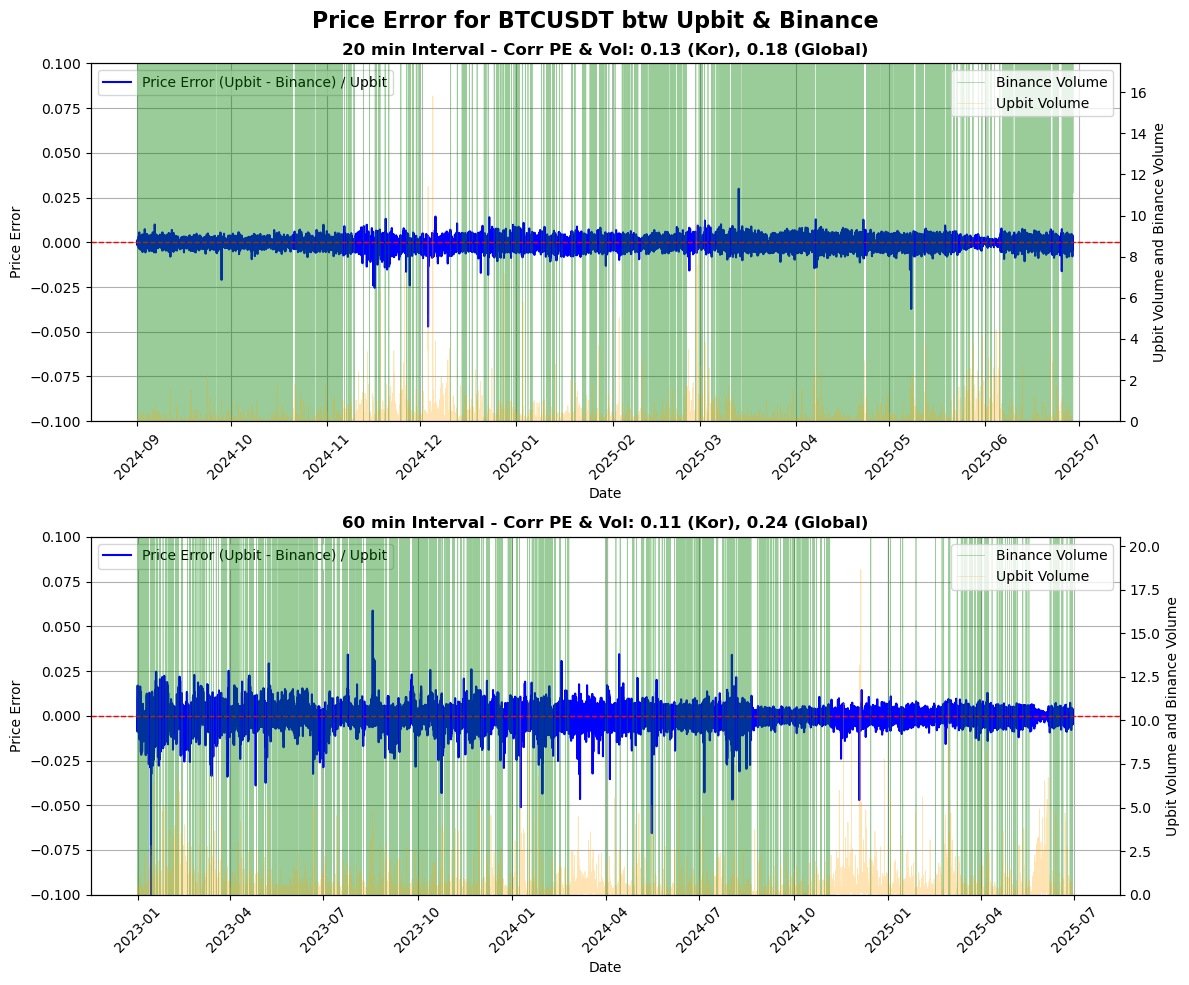

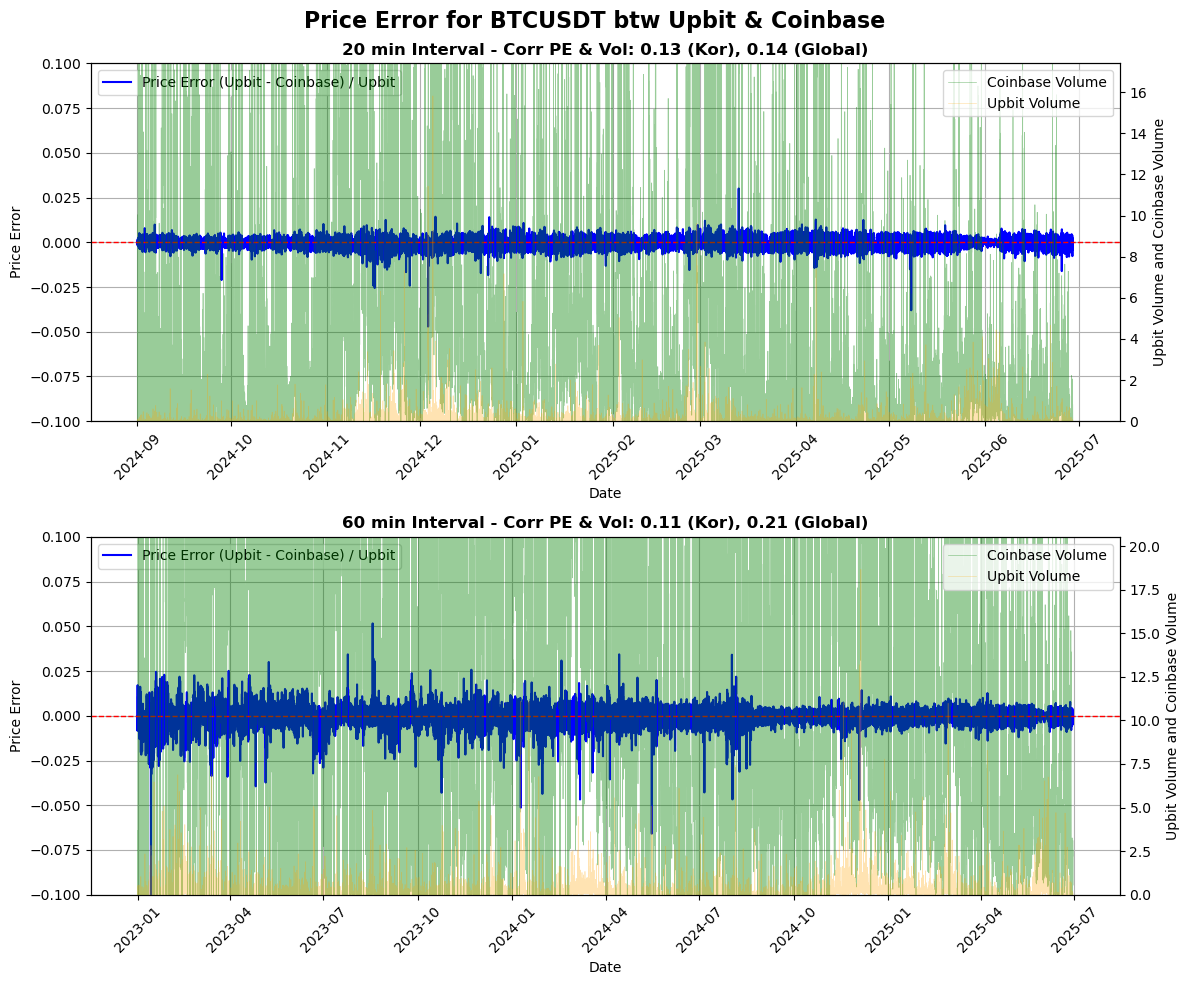

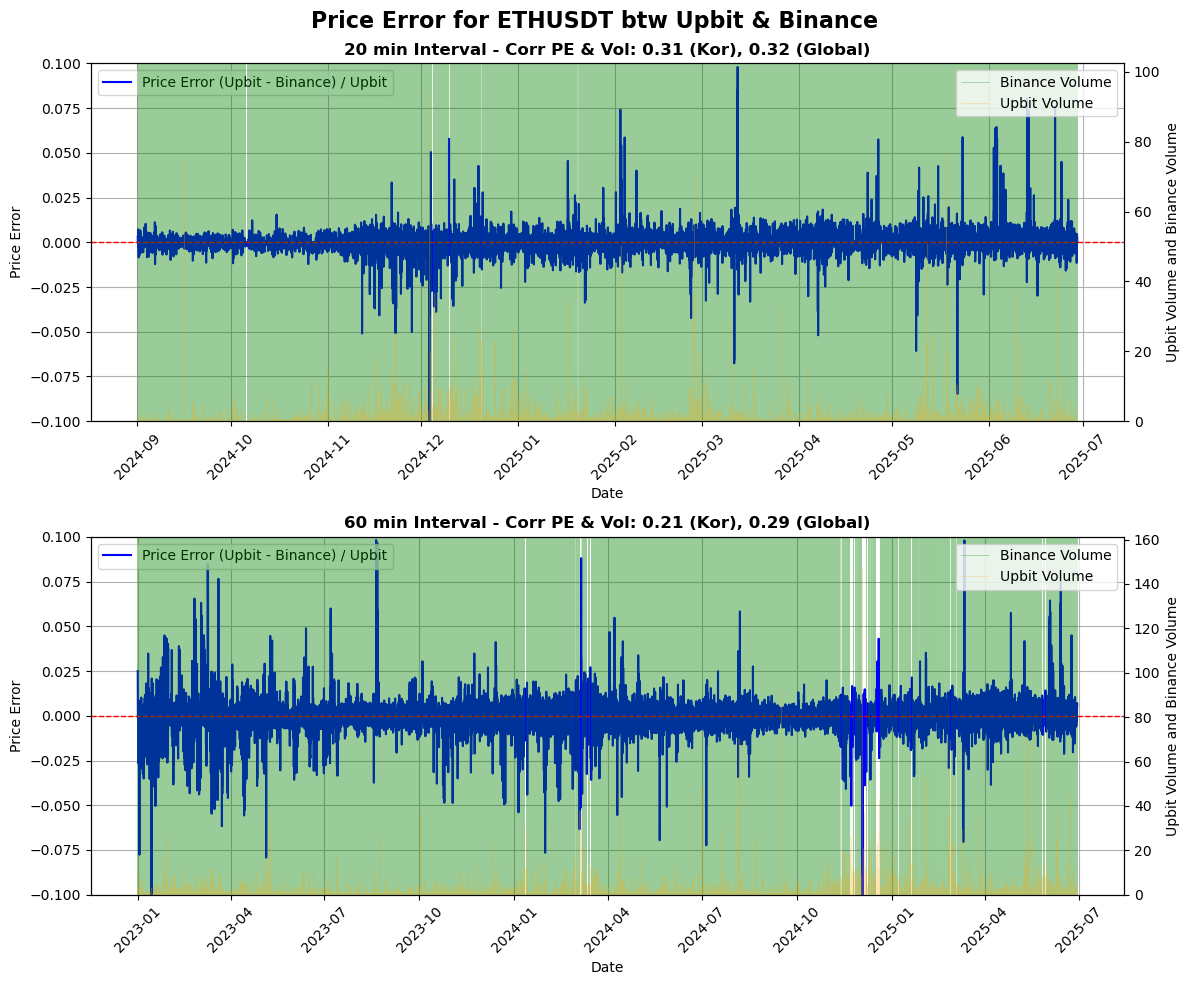

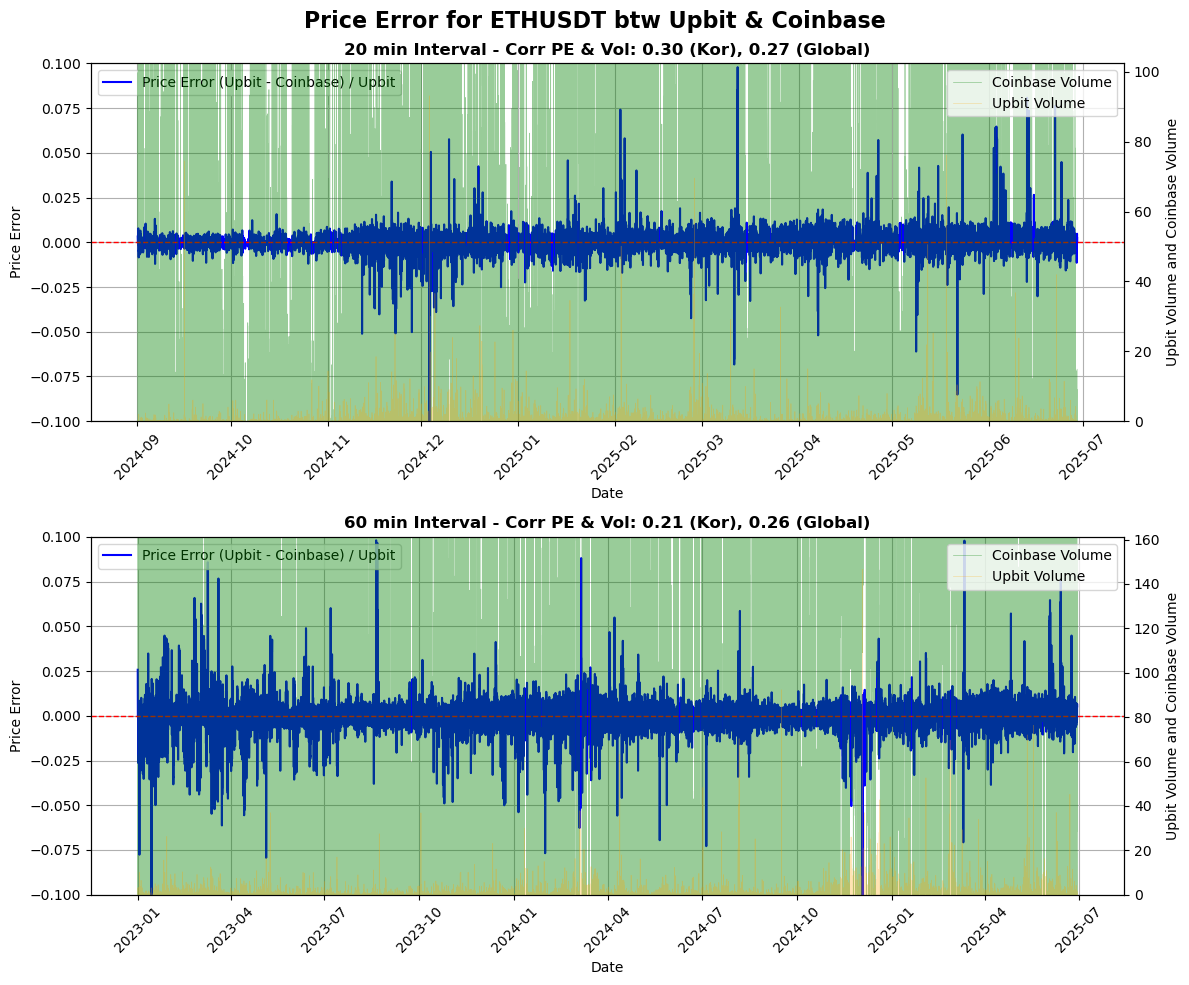

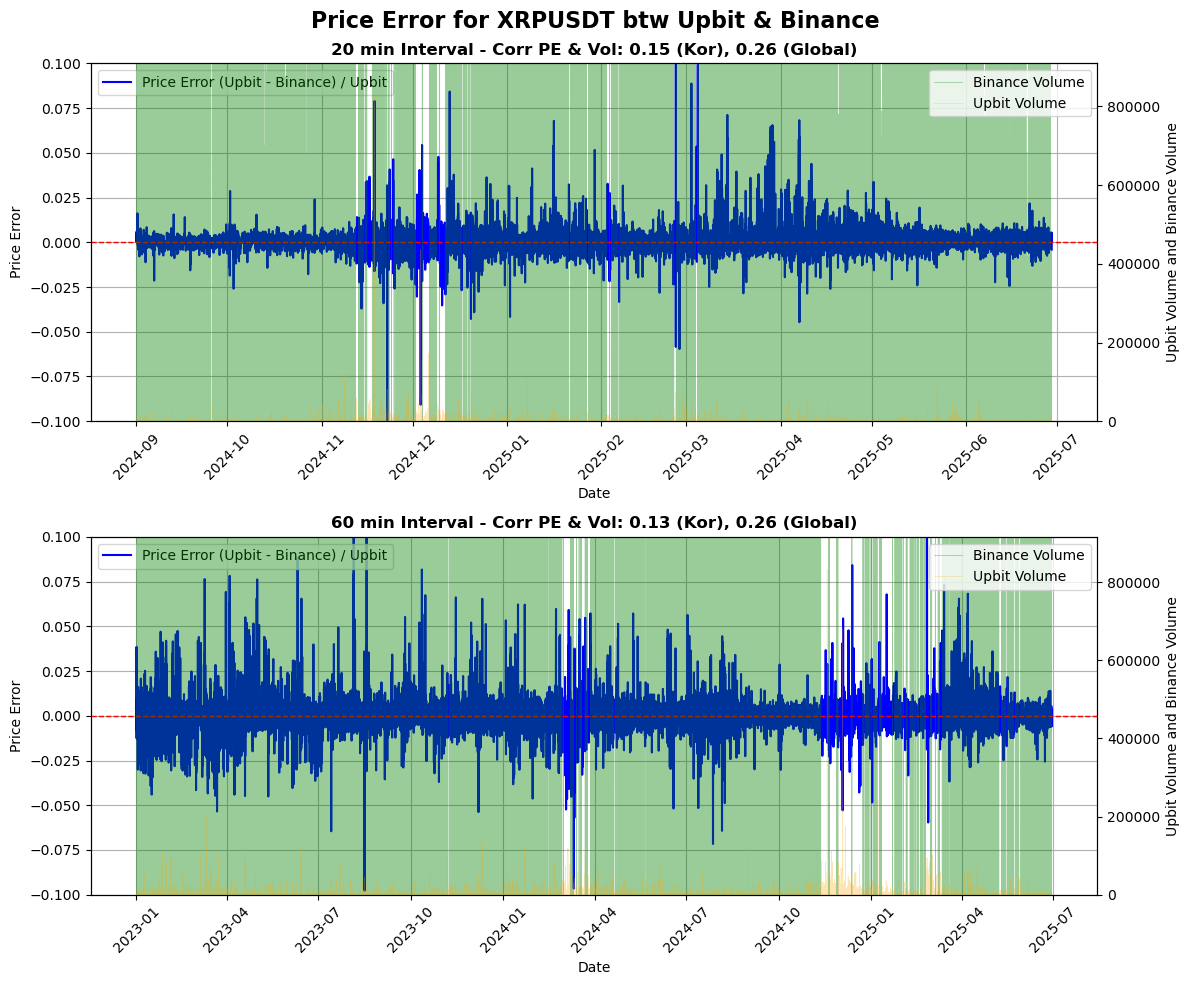

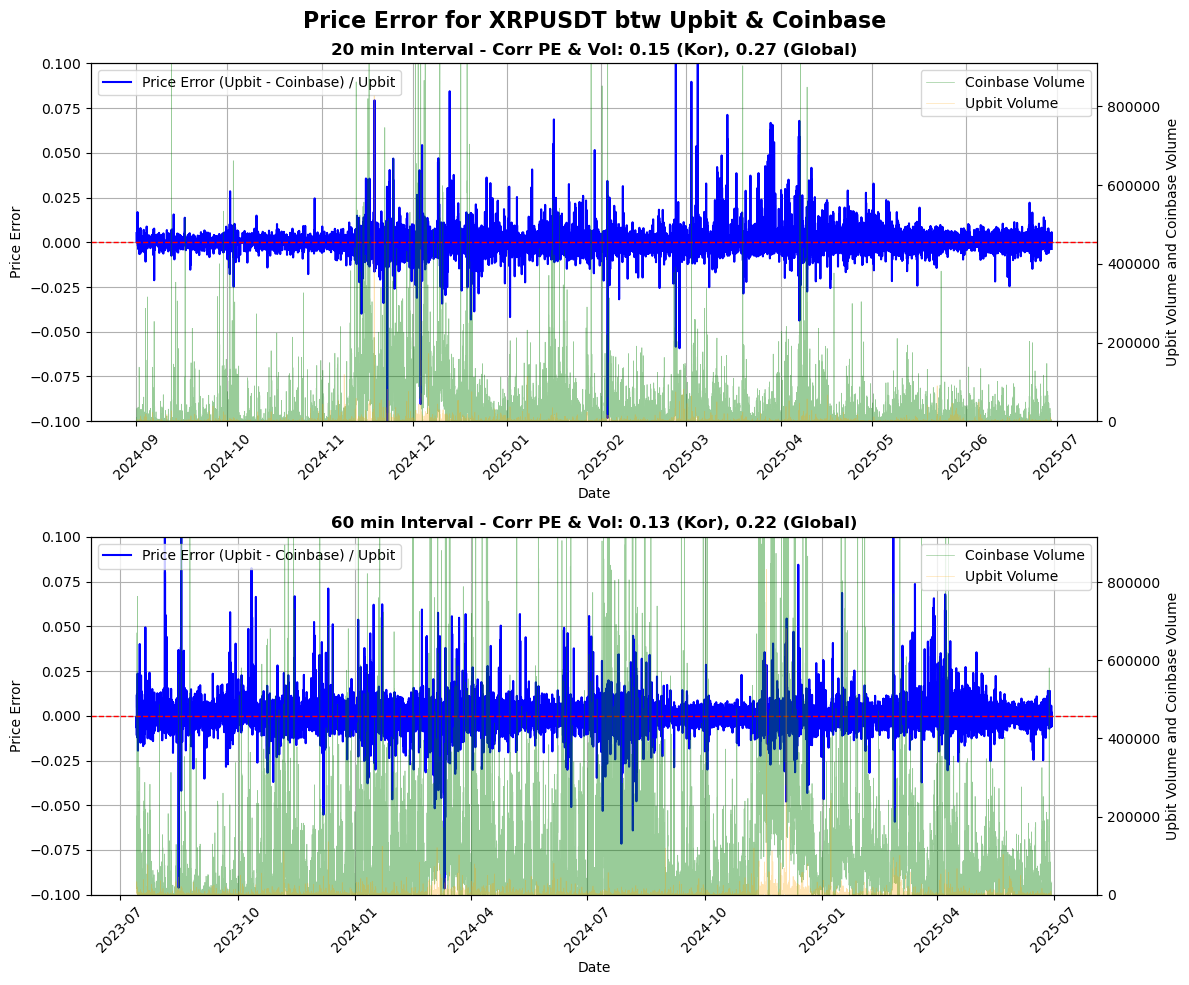

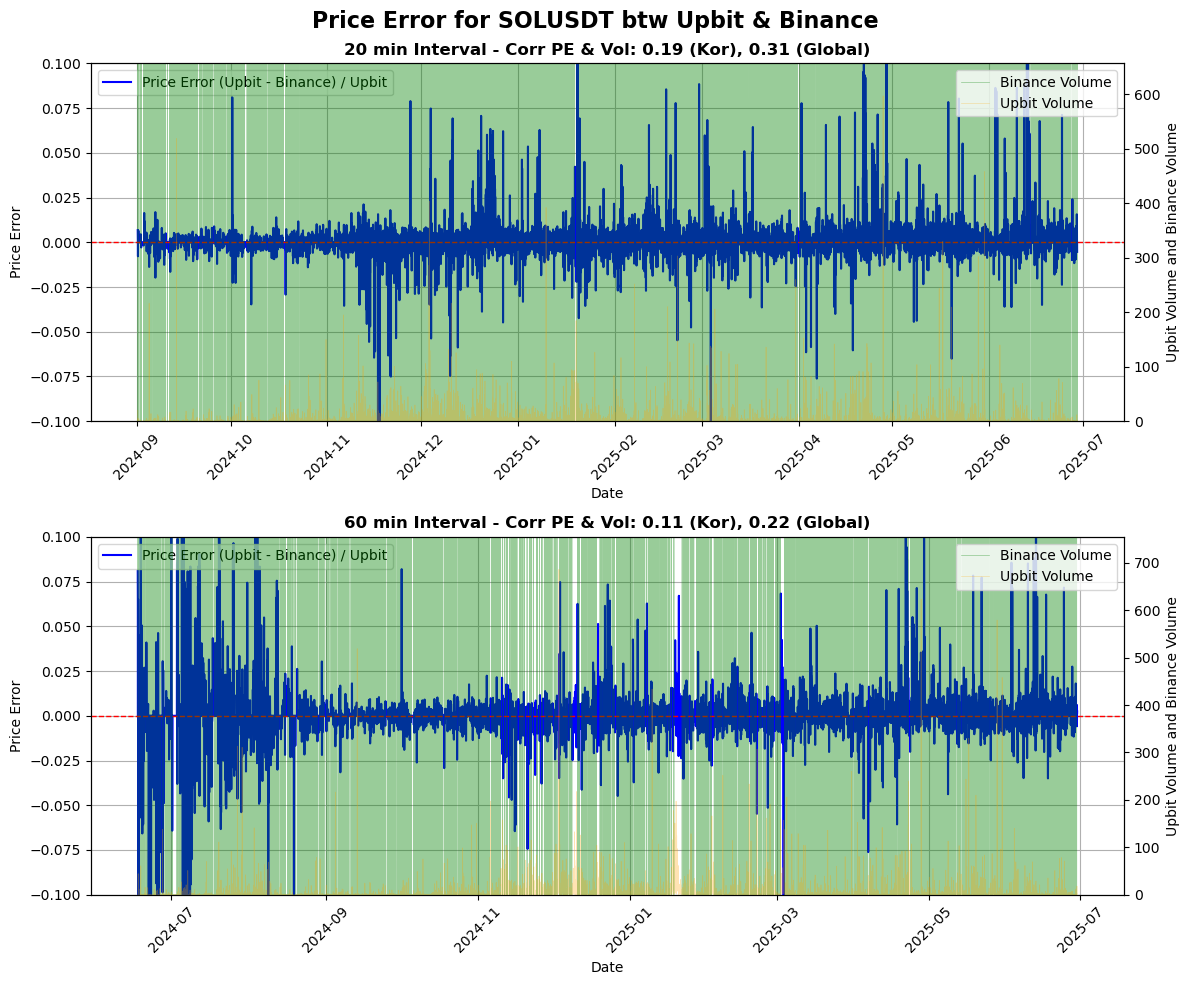

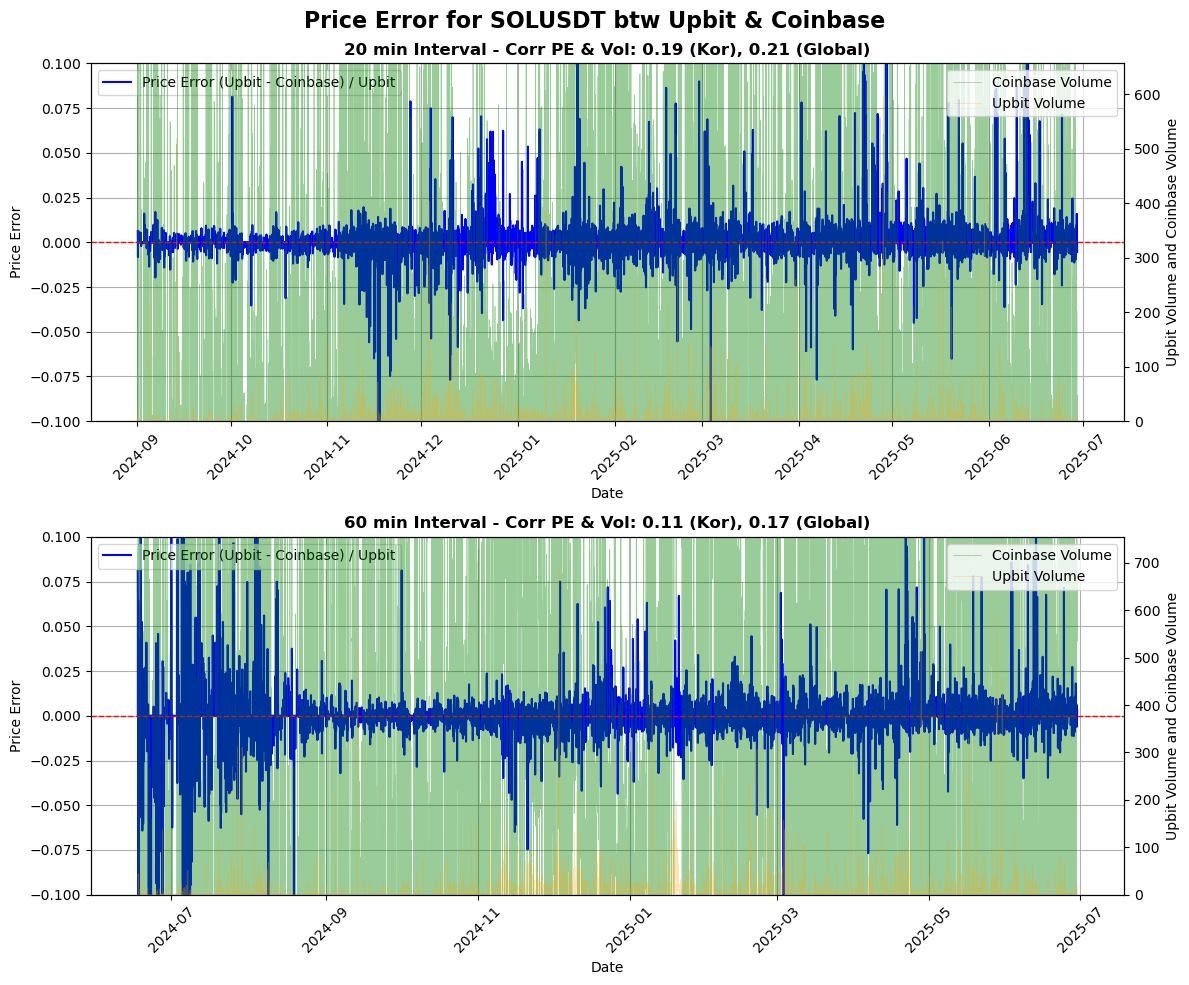

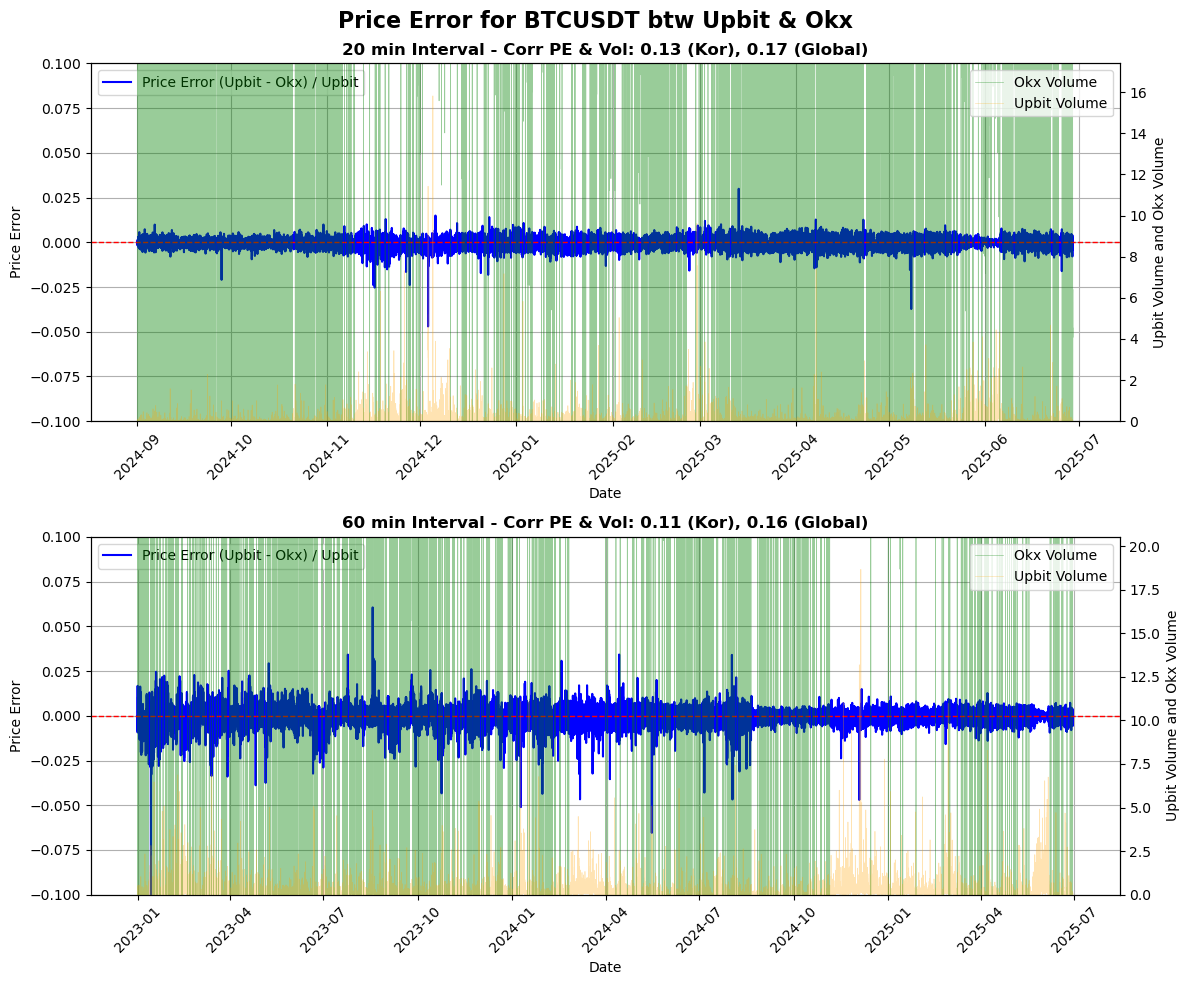

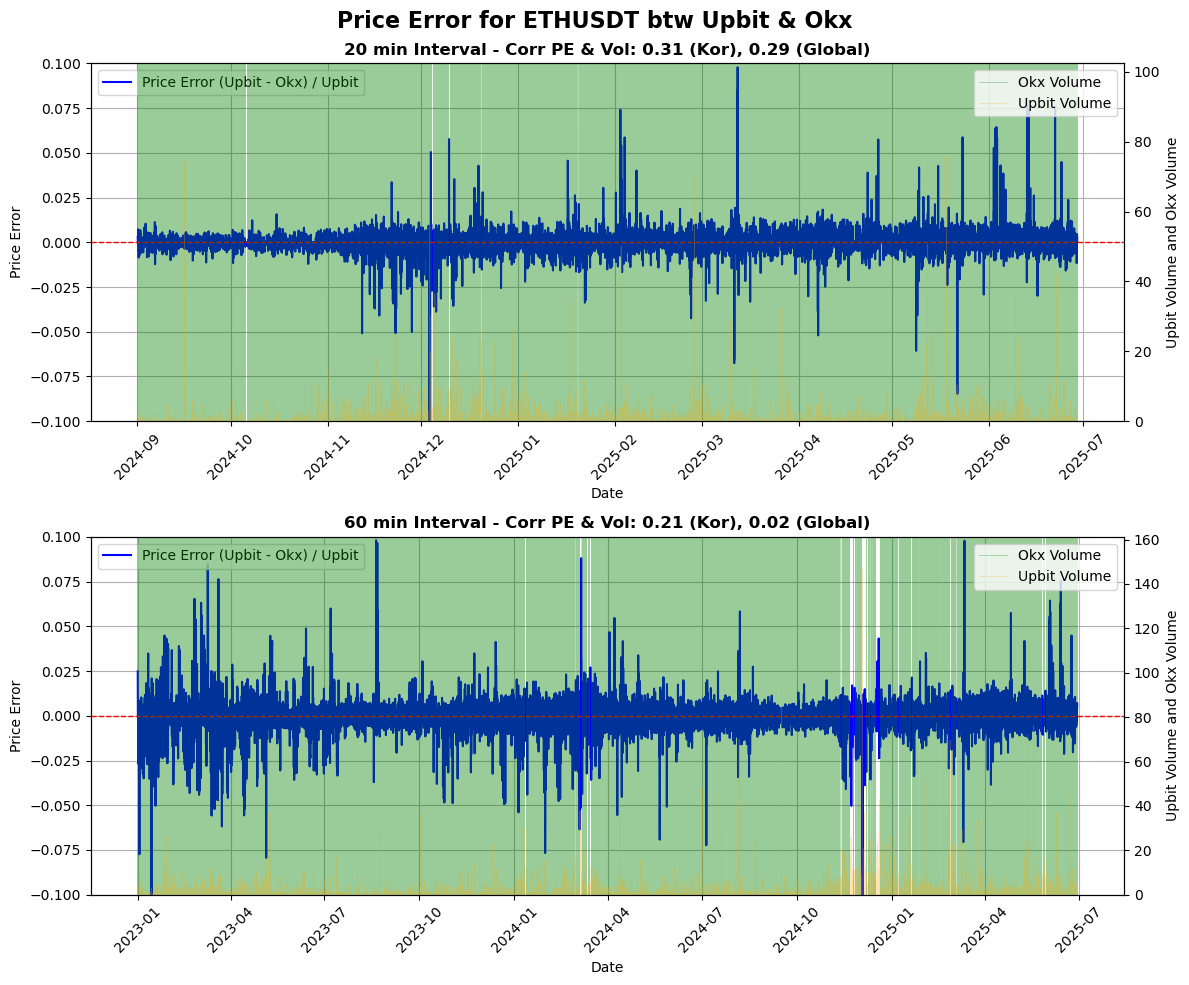

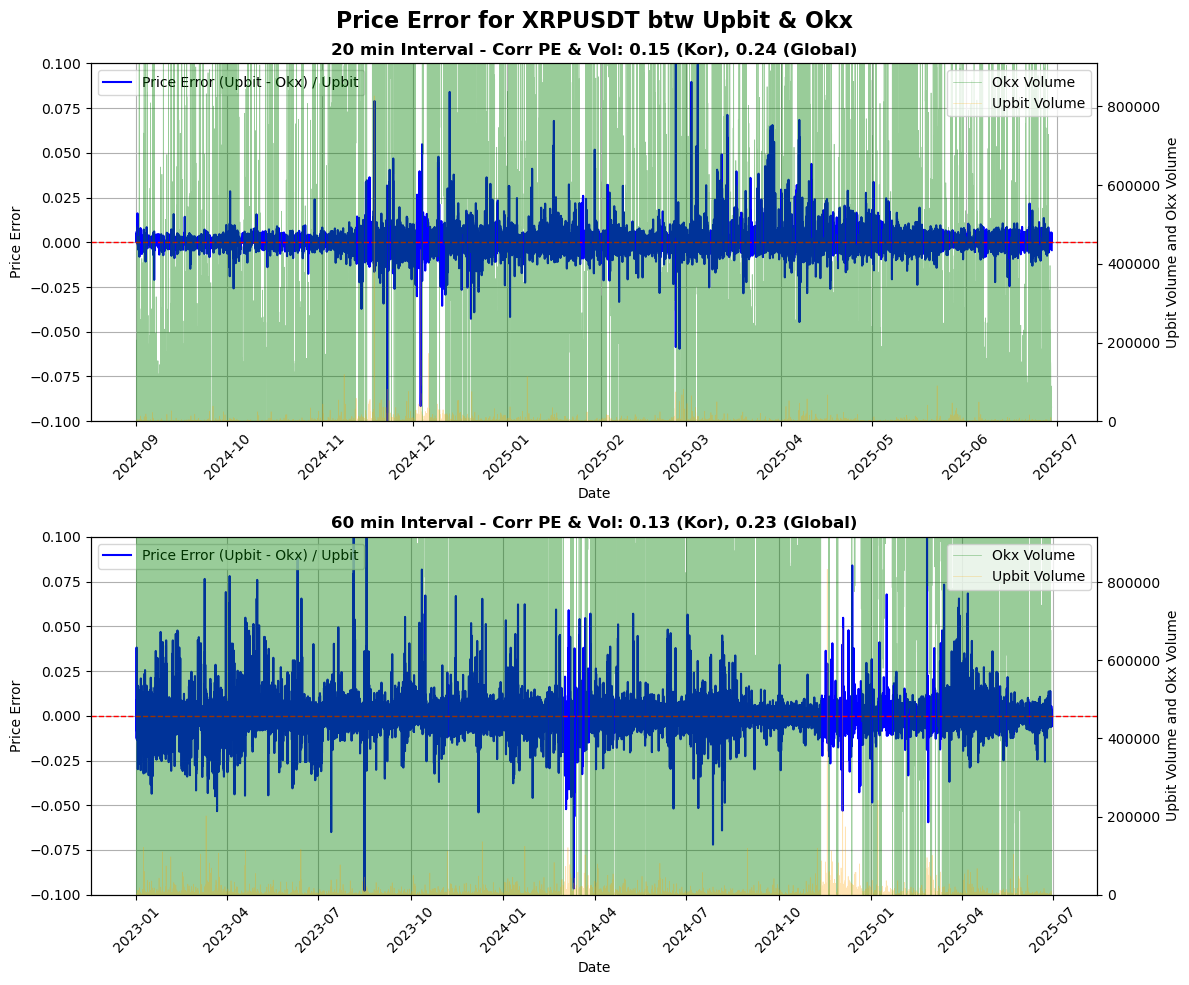

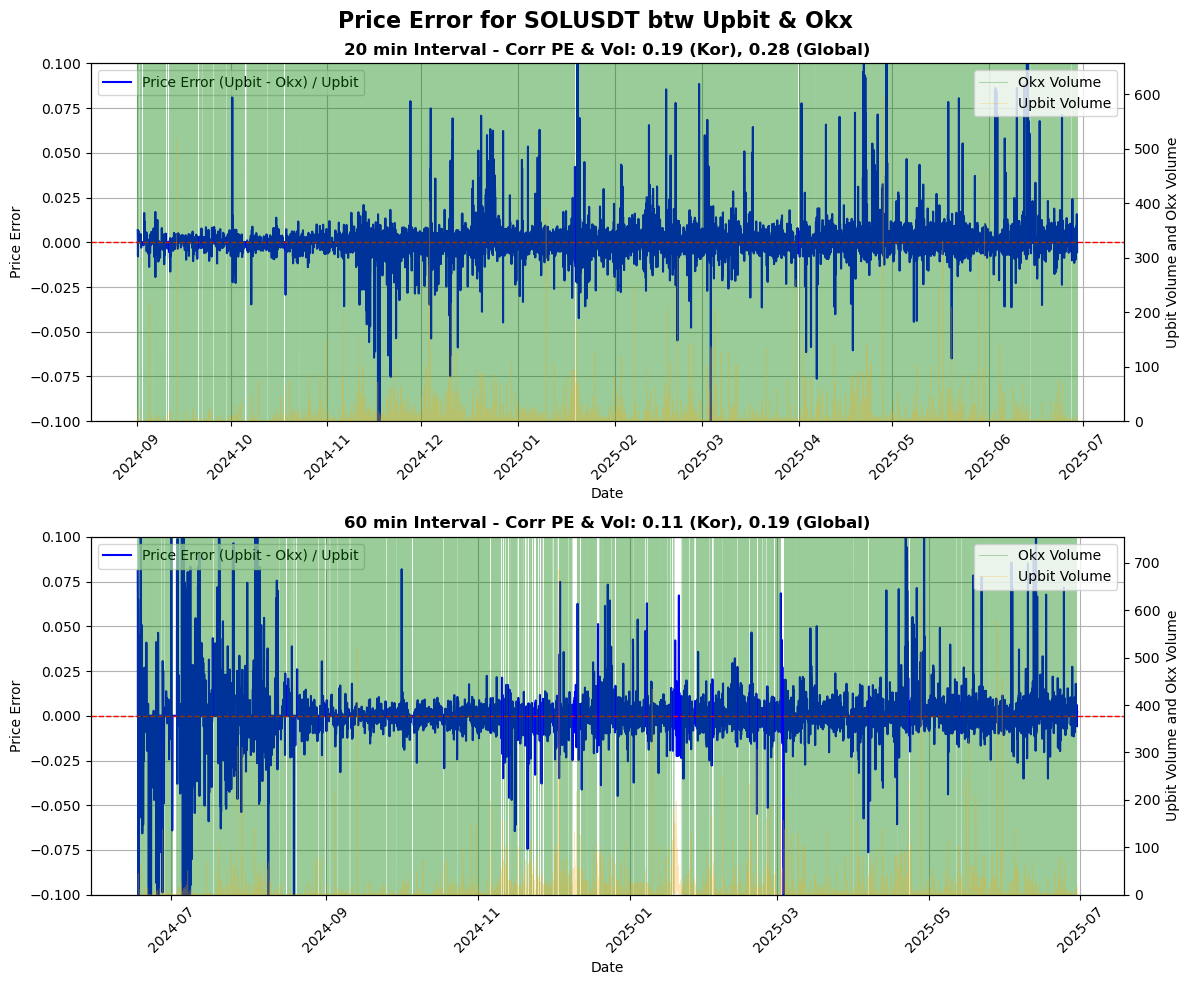

In [7]:

import matplotlib.pyplot as plt
import os

import os
root_folder = os.path.join(os.getcwd(), '../kimchi-premium')
save_root_folder = os.path.join(os.getcwd(), '../dashboard/figure')

for f in os.listdir(root_folder):
    if not f.endswith('.csv'):
        continue
    token, kor_exc, global_exc = f.split('_')[:3]
    if global_exc not in global_excs or kor_exc not in kor_excs:
        print(f"Skipping {f} as it does not match the expected exchanges.")
        continue

    print(f"Visualizing {token} - {kor_exc} vs {global_exc}")
    save_temp = os.path.join(save_root_folder, token, kor_exc, global_exc)
    os.makedirs(save_temp, exist_ok=True)

    df_merged = pd.read_csv(os.path.join(root_folder, f))
    df_merged = df_merged[df_merged.Interval <= 2000]  # 필터링: Interval이 2000 이하인 데이터만 사용
    df_merged['time'] = pd.to_datetime(df_merged['time'], utc=True)
    kor_exc, global_exc = f.split('_')[1:3]
   

    # 시각화
    groups = df_merged.groupby('Interval')
    
    fig, axs = plt.subplots(nrows=groups.ngroups, ncols=1, figsize=(12, 5* groups.ngroups))
    fig.suptitle(f'Price Error for {token} btw {kor_exc.capitalize()} & {global_exc.capitalize()}', fontweight ="bold", fontsize=16) 

    i = -1
    for g, group in groups:
        i += 1
        print(f"Processing Interval: {g}")
        df_temp = group.reset_index(drop=True).copy()
        full_range = pd.date_range(start=df_temp['time'].min(), end=df_temp['time'].max(), freq=f'{g}min')
        df_temp = df_temp.set_index('time').reindex(full_range).reset_index().rename(columns={'index': 'time'})
        min_date = df_temp['time'].dt.date.min()
        max_date = df_temp['time'].dt.date.max()

        df_temp[f'Volume_{kor_exc}'] = df_temp[f'Volume_{kor_exc}'].fillna(0)
        df_temp[f'Volume_{global_exc}'] = df_temp[f'Volume_{global_exc}'].fillna(0)
        df_temp.price_error = df_temp['price_error'].fillna(0) 

        axs[i].plot(df_temp['time'], df_temp['price_error'],
                label=f'Price Error ({kor_exc.capitalize()} - {global_exc.capitalize()}) / {kor_exc.capitalize()}',
                color='blue', linewidth=1.5, zorder=3)
        axs[i].axhline(0, color='red', linestyle='--', linewidth=1, zorder=4)
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Price Error')
        axs[i].tick_params(axis='x', rotation=45)
        axs[i].legend(loc='upper left')
        corr_kor = df_temp['price_error'].abs().corr(df_temp[f'Volume_{kor_exc}'])
        corr_oth = df_temp['price_error'].abs().corr(df_temp[f'Volume_{global_exc}'])
        axs[i].set_title(f'{g} min Interval - Corr PE & Vol: {corr_kor:.2f} (Kor), {corr_oth:.2f} (Global)', fontsize=12, fontweight='bold')

        ax2 = axs[i].twinx()
        # ax2.plot(df_temp['time'], df_temp[f'Volume_{global_exc}'],
        #          label=f'{global_exc.capitalize()} Volume', color='green', linewidth=0.5, alpha=0.4, zorder=1)
        ax2.plot(df_temp['time'], df_temp[f'Volume_{kor_exc}'],
                label=f'{kor_exc.capitalize()} Volume', color='orange', linewidth=0.5, alpha=0.3, zorder=1)

        ax2.set_ylabel(f'{kor_exc.capitalize()} Volume')
        ax2.legend(loc='upper right')
        axs[i].set_ylim(-0.1, 0.1)
        ax2.set_ylim(0, df_temp[f'Volume_{kor_exc}'].max() * 1.1)
        axs[i].grid(True)
        
    fig.tight_layout()
    plt.savefig(os.path.join(os.path.join(os.getcwd(), save_temp), f'price_error_{min_date}_{max_date}.png'))